# Import Gene Annotation File

https://github.com/hakha-most/gwas_eqtl/blob/master/gene_annotations/genes.protein_coding.v39.gtf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip

# Local path to GTF file
gtf_file_path = '/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Data/genes.protein_coding.v39.gtf'
# Path to GWAS file
gwas_file_path = '/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Data/50_irnt.gwas.imputed_v3.both_sexes.tsv.bgz'
# Path to S Het file
s_het_file_path = '/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Data/s_het_info.xlsx'

# Load the GTF file into a pandas DataFrame and use the first row as headers
gtf_df = pd.read_csv(gtf_file_path, sep='\t', header=0)

# Display the first few rows of the dataframe
gtf_df.sort_values('start')
gtf_df.head()

#how many closest genes we want to find
n_closest = 5

In [2]:
gtf_df

,chr,start,end,strand,GeneSymbol,cons,gene,hgnc_id,tss,tes
0,chr1,65419,71585,+,ENSG00000186092,protein_coding,OR4F5,HGNC:14825,65419,71585
1,chr1,621096,622034,-,ENSG00000284662,protein_coding,OR4F16,HGNC:15079,622034,621096
2,chr1,859303,879955,+,ENSG00000187634,protein_coding,SAMD11,HGNC:28706,859303,879955
3,chr1,879583,894689,-,ENSG00000188976,protein_coding,NOC2L,HGNC:24517,894689,879583
4,chr1,895964,901099,+,ENSG00000187961,protein_coding,KLHL17,HGNC:24023,895964,901099
...,...,...,...,...,...,...,...,...,...,...
18327,chr22,51039222,51052409,+,ENSG00000008735,protein_coding,MAPK8IP2,HGNC:6883,51039222,51052409
18328,chr22,51061182,51066601,-,ENSG00000100299,protein_coding,ARSA,HGNC:713,51066601,51061182
18329,chr22,51112843,51171726,+,ENSG00000251322,protein_coding,SHANK3,HGNC:14294,51112843,51171726
18330,chr22,51176624,51183767,+,ENSG00000100312,protein_coding,ACR,HGNC:126,51176624,51183767


#### convert chr to int

In [3]:
gtf_df['chr'] = gtf_df['chr'].str[3:].astype(int)
gtf_df['start'] = gtf_df['start'].astype(int)

In [4]:
gtf_df.groupby('chr')['start'].agg({'min', 'max'}).reset_index()

,chr,max,min
0,1,249200395,65419
1,2,242836139,38814
2,3,197687071,238446
3,4,190945522,53180
4,5,180794269,92283
5,6,170884383,291630
6,7,158820866,330136
7,8,146277851,116086
8,9,140772234,14475
9,10,135437399,92828


Positions reset for each chromosome

### File Description

This file contains **gene annotations** for **protein-coding genes** and provides information about the **location of genes on the genome**. Below is a description of each column:

1. **chr**: The chromosome where the gene is located (e.g., `chr1`, `chr2`, etc.).
2. **start**: The start position of the gene on the chromosome (in base pairs).
3. **end**: The end position of the gene on the chromosome (in base pairs).
4. **strand**: Indicates the strand on which the gene is located (`+` for forward strand, `-` for reverse strand).
5. **GeneSymbol**: The symbol or name of the gene (e.g., `OR4F5`, `SAMD11`), typically assigned by organizations like HGNC (HUGO Gene Nomenclature Committee).
6. **cons**: This column indicates the type of gene. In this file, all genes are classified as **protein_coding**.
7. **gene**: The Ensembl gene ID, a unique identifier for the gene (e.g., `ENSG00000186092`).
8. **hgnc_id**: The unique identifier for the gene assigned by the **HGNC** (HUGO Gene Nomenclature Committee).
9. **tss**: The **transcription start site**, the position where transcription of the gene starts on the chromosome.
10. **tes**: The **transcription end site**, the position where transcription of the gene ends on the chromosome.

# Import GWAS data

 https://docs.google.com/spreadsheets/d/1kvPoupSzsSFBNSztMzl04xMoSC3Kcx3CrjVf4yBmESU/edit?gid=178908679#gid=178908679 (row 7217)
 
 50_irnt.gwas.imputed_v3.both_sexes.tsv.bgz' 

In [5]:
# Open and read the compressed .bgz file using gzip
with gzip.open(gwas_file_path, 'rt') as f:
    # Load the file into a pandas DataFrame
    gwas_df = pd.read_csv(f, sep='\t')

In [6]:
# Display the first few rows to inspect the structure of the GWAS file
gwas_df

,variant,minor_allele,minor_AF,low_confidence_variant,n_complete_samples,AC,ytx,beta,se,tstat,pval
0,1:15791:C:T,T,5.440760e-09,True,360388,0.003922,0.003474,18.049900,178.468000,0.101138,0.919441
1,1:69487:G:A,A,5.761760e-06,True,360388,4.152940,-0.087536,-0.041345,0.349577,-0.118272,0.905852
2,1:69569:T:C,C,1.881580e-04,True,360388,135.620000,-2.079970,-0.046994,0.062695,-0.749571,0.453514
3,1:139853:C:T,T,5.674710e-06,True,360388,4.090200,-0.105659,-0.042056,0.349588,-0.120302,0.904244
4,1:692794:CA:C,C,1.106010e-01,False,360388,79718.500000,101.503000,0.000797,0.002899,0.274788,0.783479
...,...,...,...,...,...,...,...,...,...,...,...
13791462,X:154929412:C:T,T,2.454380e-01,False,360388,176906.000000,-787.373000,-0.001657,0.001588,-1.044020,0.296477
13791463,X:154929637:CT:C,C,2.297000e-01,False,360388,165562.000000,-734.113000,-0.001654,0.001657,-0.998454,0.318060
13791464,X:154929952:CAA:C,C,2.393990e-01,False,360388,172553.000000,-480.000000,-0.001689,0.001670,-1.011490,0.311783
13791465,X:154930230:A:G,G,2.458510e-01,False,360388,177204.000000,-706.111000,-0.001520,0.001587,-0.957369,0.338381


### GWAS Summary Statistics Dataset Description

1. **variant**: The unique identifier for each SNP (Single Nucleotide Polymorphism). This can include information like chromosome, position, reference allele, and alternative allele (e.g., `1:12345:A:G`).
   - **Example**: `1:10583:T:G`

2. **minor_allele**: The allele that is less frequent in the population (minor allele) for this particular SNP.
   - **Example**: `G`

3. **minor_AF**: The **minor allele frequency** (AF), which represents the frequency of the minor allele in the population. It ranges from 0 to 1.
   - **Example**: `0.35` (35% of individuals carry the minor allele)

4. **low_confidence_variant**: A flag indicating whether the variant has **low confidence** due to imputation quality or other uncertainties. Values may be `TRUE` or `FALSE`.
   - **Example**: `FALSE`

5. **n_complete_samples**: The number of samples for which complete genotype data is available for this variant.
   - **Example**: `300,000`

6. **AC**: The **allele count** of the minor allele, i.e., the number of times the minor allele appears in the study population (across all samples).
   - **Example**: `50000`

7. **ytx**: Likely a placeholder for a phenotype-related statistic; depending on the dataset, this could represent something like the trait mean or effect size (its exact meaning depends on the specific analysis).

8. **beta**: The **effect size** of the SNP on the trait being studied (in this case, likely height). It represents the change in the trait per additional copy of the minor allele.
   - **Example**: `0.05` (the trait increases by 0.05 units for each additional copy of the minor allele)

9. **se**: The **standard error** of the effect size (beta), indicating the precision of the estimated effect.
   - **Example**: `0.01`

10. **tstat**: The **t-statistic** for the beta estimate, which is the ratio of the beta estimate to its standard error.
    - **Example**: `5.0` (higher values indicate more significant associations)

11. **pval**: The **p-value** of the association between the SNP and the trait. This indicates the significance of the result, with smaller p-values suggesting stronger evidence that the SNP is associated with the trait.
    - **Example**: `1.2e-6` (a very small p-value, indicating strong evidence of association)

In [7]:
gwas_df.shape

(13791467, 11)

# Find Variant Chromosome and Position

In [8]:
gwas_df[['chr', 'pos', 'ref', 'alt']] = gwas_df['variant'].str.split(':', expand=True)
gwas_df.head(1)

,variant,minor_allele,minor_AF,low_confidence_variant,n_complete_samples,AC,ytx,beta,se,tstat,pval,chr,pos,ref,alt
0,1:15791:C:T,T,5.440760e-09,True,360388,0.003922,0.003474,18.0499,178.468,0.101138,0.919441,1,15791,C,T


In [9]:
gwas_df = gwas_df[gwas_df['chr'] != 'X']
gwas_df['chr'] = gwas_df['chr'].astype(int)
gwas_df['pos'] = gwas_df['pos'].astype(int)

/var/folders/6r/gppxzrp57j9ggbttd9chp8cm0000gn/T/ipykernel_50133/4273199762.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_df['chr'] = gwas_df['chr'].astype(int)
/var/folders/6r/gppxzrp57j9ggbttd9chp8cm0000gn/T/ipykernel_50133/4273199762.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gwas_df['pos'] = gwas_df['pos'].astype(int)


In [10]:
gwas_df.groupby('chr')['pos'].agg({'min','max'}).reset_index()

,chr,max,min
0,1,249230914,15791
1,2,243082521,10181
2,3,197900375,60197
3,4,190922257,13012
4,5,180736061,11882
5,6,170934414,202076
6,7,159128550,27916
7,8,146303560,34440
8,9,141104957,40997
9,10,135503523,61334


It appears that position resets on each chromosome 

# Join to Find 5 Nearest Genes 

In [11]:
#here we are performing how far the start of our mutation is from the start of the 
#following genes

In [12]:
#allow exact matches is false
#so we are not allowing there to be a mutation that is the same as teh start of a gene
#why
#is it to avoid div by 0?

In [13]:
#so this finds the three closest forward genes
#what if all the closest are fwd vs all the closest are backward
#should we not find teh 5 fwd and 5 bck and then compare?

In [14]:
def repeated_forward_merge(gwas_df, gtf_df, num_merges= n_closest):
    # Initial sorting of key columns for the first merge
    gwas_sorted = gwas_df[['variant', 'pval', 'chr', 'pos']].sort_values('pos')
    gtf_sorted = gtf_df[['chr', 'start', 'GeneSymbol', 'gene']].sort_values('start')

    # Ensure both 'start' columns are of the same type (convert to float to handle NaNs)
    gtf_sorted['start'] = gtf_sorted['start'].astype(float)
    gwas_sorted['pos'] = gwas_sorted['pos'].astype(float)

    # First merge_asof
    merged_df = pd.merge_asof(
        gwas_sorted, 
        gtf_sorted, 
        by='chr', 
        left_on='pos', 
        right_on='start', 
        direction='forward',
        suffixes=('', '_f1')  # First set of suffixes
    )

    # Replace NaN values in 'start' column and rename for subsequent merges
    merged_df['start'] = merged_df['start'].fillna(np.inf)
    merged_df = merged_df.rename(columns={'start': 'start_f1', 'GeneSymbol': 'GeneSymbol_f1', 'gene': 'gene_f1'})
    merged_df = merged_df.sort_values('start_f1')

    # Iterative forward merges
    for i in range(2, num_merges + 1):
        # Ensure both columns are of the same type
        merged_df[f'start_f{i-1}'] = merged_df[f'start_f{i-1}'].astype(float)
        gtf_sorted['start'] = gtf_sorted['start'].astype(float)

        # Perform the next forward merge
        merged_df = pd.merge_asof(
            merged_df, 
            gtf_sorted, 
            by='chr', 
            left_on=f'start_f{i-1}', 
            right_on='start', 
            direction='forward',
            allow_exact_matches=False,
            suffixes=(f'_f{i-1}', f'_f{i}')
        )

        # Replace NaN values in the new 'start' column and rename for next iteration
        merged_df['start'] = merged_df['start'].fillna(np.inf)
        merged_df = merged_df.rename(columns={
            'start': f'start_f{i}', 
            'GeneSymbol': f'GeneSymbol_f{i}', 
            'gene': f'gene_f{i}'
        })
        merged_df = merged_df.sort_values(f'start_f{i}')

    # After the last merge, replace all np.inf values back to NaN
    for i in range(1, num_merges + 1):
        merged_df[f'start_f{i}'] = merged_df[f'start_f{i}'].replace(np.inf, np.nan)
    
    return merged_df

f_final = repeated_forward_merge(gwas_df, gtf_df, num_merges=n_closest)

In [15]:
f_final

,variant,pval,chr,pos,start_f1,GeneSymbol_f1,gene_f1,start_f2,GeneSymbol_f2,gene_f2,start_f3,GeneSymbol_f3,gene_f3,start_f4,GeneSymbol_f4,gene_f4,start_f5,GeneSymbol_f5,gene_f5
0,16:94919:G:A,0.557584,16,94919.0,96407.0,ENSG00000161980,POLR3K,103828.0,ENSG00000161981,SNRNP25,108058.0,ENSG00000007384,RHBDF1,127006.0,ENSG00000103152,MPG,134270.0,ENSG00000103148,NPRL3
72,16:88529:C:T,0.610190,16,88529.0,96407.0,ENSG00000161980,POLR3K,103828.0,ENSG00000161981,SNRNP25,108058.0,ENSG00000007384,RHBDF1,127006.0,ENSG00000103152,MPG,134270.0,ENSG00000103148,NPRL3
71,16:94585:AGATCAGGAGGCT:A,0.641873,16,94585.0,96407.0,ENSG00000161980,POLR3K,103828.0,ENSG00000161981,SNRNP25,108058.0,ENSG00000007384,RHBDF1,127006.0,ENSG00000103152,MPG,134270.0,ENSG00000103148,NPRL3
70,16:83887:C:A,0.955567,16,83887.0,96407.0,ENSG00000161980,POLR3K,103828.0,ENSG00000161981,SNRNP25,108058.0,ENSG00000007384,RHBDF1,127006.0,ENSG00000103152,MPG,134270.0,ENSG00000103148,NPRL3
69,16:89077:G:A,0.477961,16,89077.0,96407.0,ENSG00000161980,POLR3K,103828.0,ENSG00000161981,SNRNP25,108058.0,ENSG00000007384,RHBDF1,127006.0,ENSG00000103152,MPG,134270.0,ENSG00000103148,NPRL3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13324773,4:189124592:T:C,0.146931,4,189124592.0,190862025.0,ENSG00000109536,FRG1,190945522.0,ENSG00000205097,FRG2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13324774,4:190843675:C:T,0.550784,4,190843675.0,190862025.0,ENSG00000109536,FRG1,190945522.0,ENSG00000205097,FRG2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13324775,4:189124184:GT:G,0.708610,4,189124184.0,190862025.0,ENSG00000109536,FRG1,190945522.0,ENSG00000205097,FRG2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13324777,4:189109193:T:C,0.162214,4,189109193.0,190862025.0,ENSG00000109536,FRG1,190945522.0,ENSG00000205097,FRG2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Adjusted function to ensure all negative infinity values are replaced with NaN in the final result
def repeated_backward_merge_with_nan(gwas_df, gtf_df, num_merges=n_closest):
    # Initial sorting of key columns for the first merge
    gwas_sorted = gwas_df.sort_values('pos')
    gtf_sorted = gtf_df[['chr', 'start', 'GeneSymbol', 'gene']].sort_values('start')

    # Ensure both 'start' columns are of the same type (convert to float to handle NaNs)
    gtf_sorted['start'] = gtf_sorted['start'].astype(float)
    gwas_sorted['pos'] = gwas_sorted['pos'].astype(float)

    # First backward merge_asof
    merged_df = pd.merge_asof(
        gwas_sorted, 
        gtf_sorted, 
        by='chr', 
        left_on='pos', 
        right_on='start', 
        direction='backward',
        suffixes=('', '_b1')  # First set of suffixes
    )

    # Replace NaN values in 'start' column and rename for subsequent merges
    merged_df['start'] = merged_df['start'].fillna(-np.inf)
    merged_df = merged_df.rename(columns={'start': 'start_b1', 'GeneSymbol': 'GeneSymbol_b1', 'gene': 'gene_b1'})
    merged_df = merged_df.sort_values('start_b1')

    # Iterative backward merges
    for i in range(2, num_merges + 1):
        # Ensure both columns are of the same type
        merged_df[f'start_b{i-1}'] = merged_df[f'start_b{i-1}'].astype(float)
        gtf_sorted['start'] = gtf_sorted['start'].astype(float)

        # Perform the next backward merge
        merged_df = pd.merge_asof(
            merged_df, 
            gtf_sorted, 
            by='chr', 
            left_on=f'start_b{i-1}', 
            right_on='start', 
            direction='backward',
            allow_exact_matches=False,
            suffixes=(f'_b{i-1}', f'_b{i}')
        )

        # Replace NaN values in the new 'start' column and rename for next iteration
        merged_df['start'] = merged_df['start'].fillna(-np.inf)
        merged_df = merged_df.rename(columns={
            'start': f'start_b{i}', 
            'GeneSymbol': f'GeneSymbol_b{i}', 
            'gene': f'gene_b{i}'
        })
        merged_df = merged_df.sort_values(f'start_b{i}')

    # After the last merge, replace all -np.inf values back to NaN
    for i in range(1, num_merges + 1):
        merged_df[f'start_b{i}'] = merged_df[f'start_b{i}'].replace(-np.inf, np.nan)
    
    return merged_df

# Example usage:
f_b_final = repeated_backward_merge_with_nan(f_final, gtf_df, num_merges=n_closest)

In [17]:
f_b_final

,variant,pval,chr,pos,start_f1,GeneSymbol_f1,gene_f1,start_f2,GeneSymbol_f2,gene_f2,...,gene_b2,start_b3,GeneSymbol_b3,gene_b3,start_b4,GeneSymbol_b4,gene_b4,start_b5,GeneSymbol_b5,gene_b5
0,17:302:T:TA,0.281579,17,302.0,5810.0,ENSG00000272636,DOC2B,62180.0,ENSG00000181031,RPH3AL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50036,21:15357076:C:A,0.573263,21,15357076.0,15481134.0,ENSG00000188992,LIPI,15588451.0,ENSG00000185272,RBM11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50035,21:15357104:C:G,0.572347,21,15357104.0,15481134.0,ENSG00000188992,LIPI,15588451.0,ENSG00000185272,RBM11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50034,21:15366358:A:G,0.789949,21,15366358.0,15481134.0,ENSG00000188992,LIPI,15588451.0,ENSG00000185272,RBM11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50033,21:15212919:G:C,0.094328,21,15212919.0,15481134.0,ENSG00000188992,LIPI,15588451.0,ENSG00000185272,RBM11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13364242,1:249205823:G:A,0.918853,1,249205823.0,NaN,NaN,NaN,NaN,NaN,NaN,...,ZNF692,249132409.0,ENSG00000171161,ZNF672,249104645.0,ENSG00000175137,SH3BP5L,248844623.0,ENSG00000189181,OR14I1
13364241,1:249205806:T:C,0.989577,1,249205806.0,NaN,NaN,NaN,NaN,NaN,NaN,...,ZNF692,249132409.0,ENSG00000171161,ZNF672,249104645.0,ENSG00000175137,SH3BP5L,248844623.0,ENSG00000189181,OR14I1
13364240,1:249205774:T:C,0.767464,1,249205774.0,NaN,NaN,NaN,NaN,NaN,NaN,...,ZNF692,249132409.0,ENSG00000171161,ZNF672,249104645.0,ENSG00000175137,SH3BP5L,248844623.0,ENSG00000189181,OR14I1
13364248,1:249205246:T:A,0.937160,1,249205246.0,NaN,NaN,NaN,NaN,NaN,NaN,...,ZNF692,249132409.0,ENSG00000171161,ZNF672,249104645.0,ENSG00000175137,SH3BP5L,248844623.0,ENSG00000189181,OR14I1


In [18]:
# Function to calculate differences between pos and all forward and backward start columns
def calculate_differences(df, num_merges=n_closest):
    # Calculate the difference between pos and start_f1, start_f2, ..., start_fx for forward merges
    for i in range(1, num_merges + 1):
        df[f'diff_f{i}'] = np.abs(df[f'start_f{i}'] - df['pos'])
    
    # Calculate the difference between pos and start_b1, start_b2, ..., start_bx for backward merges
    for i in range(1, num_merges + 1):
        df[f'diff_b{i}'] = np.abs(df[f'start_b{i}'] - df['pos'])
    
    return df

f_b_final_with_differences = calculate_differences(f_b_final, num_merges=n_closest)

In [19]:
f_b_final_with_differences = f_b_final_with_differences.reset_index(drop=True)

In [20]:
f_b_final_with_differences.iloc[364242].loc[['diff_f1', 'diff_f2', 'diff_f3', 'diff_f4', 'diff_f5', 'diff_b1', 'diff_b2', 'diff_b3', 'diff_b4', 'diff_b5']]

diff_f1      54818.0
diff_f2     154693.0
diff_f3     216769.0
diff_f4     270874.0
diff_f5     281997.0
diff_b1     154192.0
diff_b2     247232.0
diff_b3    3718470.0
diff_b4    4518184.0
diff_b5    4589502.0
Name: 364242, dtype: object

In [21]:
f_b_final_with_differences[['diff_f1', 'diff_f2', 'diff_f3', 'diff_b1', 'diff_b2', 'diff_b3']].mean()

diff_f1    4.507356e+05
diff_f2    8.421126e+05
diff_f3    1.120898e+06
diff_b1    4.557157e+05
diff_b2    8.418453e+05
diff_b3    1.118083e+06
dtype: float64

In [22]:
def vectorized_reorder_rename_columns(df):
    # Get all diff columns (assuming 5 forward and 5 backward)
    diff_columns = [col for col in df.columns if col.startswith('diff_')]

    # Create a DataFrame of just the diff values
    diff_df = df[diff_columns]
    
    # Get the indices of the 5 smallest diffs for each row
    diff_order = diff_df.values.argsort(axis=1)[:, :n_closest]
    
    # Function to reorder and rename a set of columns
    def reorder_and_rename(prefix):
        cols = [col.replace('diff_', prefix) for col in diff_columns]
        values = df[cols].values
        reordered = np.take_along_axis(values, diff_order, axis=1)
        return pd.DataFrame(reordered, columns=[f'{prefix[:-1]}_{i}' for i in range(1, n_closest+1)], index=df.index)

    # Reorder and rename for each set of columns
    new_dfs = [reorder_and_rename(prefix) for prefix in ['diff_', 'gene_', 'start_', 'GeneSymbol_']]
    
    # Create direction columns
    ordered_diff_columns = np.array(diff_columns)[diff_order]
    #something wrong here
    #directions = np.where(np.char.find(ordered_diff_columns.astype(str), 'f') != -1, 'f', 'b')
    directions = np.where(
    np.char.find(ordered_diff_columns.astype(str), 'diff_f') != -1,  # Check for 'diff_f' in the column names
    'f',  # Set direction as 'f'
    'b'   # Otherwise, set direction as 'b'
)
    direction_df = pd.DataFrame(directions, columns=[f'direction_{i}' for i in range(1, n_closest+1)], index=df.index)
    new_dfs.append(direction_df)
    
    # Combine all new DataFrames
    result_df = pd.concat(new_dfs, axis=1)
    
    # Add any other columns that weren't part of the reordering
    other_columns = [col for col in df.columns if not any(col.startswith(prefix) for prefix in ['diff_', 'gene_', 'start_', 'GeneSymbol_'])]
    result_df = pd.concat([result_df, df[other_columns]], axis=1)
    
    # Reorder columns to group related information together
    column_order = (
        [f'{prefix}_{i}' for i in range(1, n_closest+1) for prefix in ['diff', 'gene', 'start', 'GeneSymbol', 'direction']] +
        other_columns
    )
    
    return result_df[column_order]

f_b_final_with_differences = vectorized_reorder_rename_columns(f_b_final_with_differences)

In [23]:
f_b_final_with_differences

,diff_1,gene_1,start_1,GeneSymbol_1,direction_1,diff_2,gene_2,start_2,GeneSymbol_2,direction_2,...,direction_4,diff_5,gene_5,start_5,GeneSymbol_5,direction_5,variant,pval,chr,pos
0,5508.0,DOC2B,5810.0,ENSG00000272636,f,61878.0,RPH3AL,62180.0,ENSG00000181031,f,...,f,411441.0,VPS53,411743.0,ENSG00000141252,f,17:302:T:TA,0.281579,17,302.0
1,124058.0,LIPI,15481134.0,ENSG00000188992,f,231375.0,RBM11,15588451.0,ENSG00000185272,f,...,f,500473.0,SAMSN1,15857549.0,ENSG00000155307,f,21:15357076:C:A,0.573263,21,15357076.0
2,124030.0,LIPI,15481134.0,ENSG00000188992,f,231347.0,RBM11,15588451.0,ENSG00000185272,f,...,f,500445.0,SAMSN1,15857549.0,ENSG00000155307,f,21:15357104:C:G,0.572347,21,15357104.0
3,114776.0,LIPI,15481134.0,ENSG00000188992,f,222093.0,RBM11,15588451.0,ENSG00000185272,f,...,b,491191.0,SAMSN1,15857549.0,ENSG00000155307,f,21:15366358:A:G,0.789949,21,15366358.0
4,230821.0,POTED,14982098.0,ENSG00000166351,b,268215.0,LIPI,15481134.0,ENSG00000188992,f,...,f,644630.0,SAMSN1,15857549.0,ENSG00000155307,f,21:15212919:G:C,0.094328,21,15212919.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13364298,5428.0,PGBD2,249200395.0,ENSG00000185220,b,61618.0,ZNF692,249144205.0,ENSG00000171163,b,...,b,361200.0,OR14I1,248844623.0,ENSG00000189181,b,1:249205823:G:A,0.918853,1,249205823.0
13364299,5411.0,PGBD2,249200395.0,ENSG00000185220,b,61601.0,ZNF692,249144205.0,ENSG00000171163,b,...,b,361183.0,OR14I1,248844623.0,ENSG00000189181,b,1:249205806:T:C,0.989577,1,249205806.0
13364300,5379.0,PGBD2,249200395.0,ENSG00000185220,b,61569.0,ZNF692,249144205.0,ENSG00000171163,b,...,b,361151.0,OR14I1,248844623.0,ENSG00000189181,b,1:249205774:T:C,0.767464,1,249205774.0
13364301,4851.0,PGBD2,249200395.0,ENSG00000185220,b,61041.0,ZNF692,249144205.0,ENSG00000171163,b,...,b,360623.0,OR14I1,248844623.0,ENSG00000189181,b,1:249205246:T:A,0.937160,1,249205246.0


In [24]:
f_b_final_with_differences.columns

Index(['diff_1', 'gene_1', 'start_1', 'GeneSymbol_1', 'direction_1', 'diff_2',
       'gene_2', 'start_2', 'GeneSymbol_2', 'direction_2', 'diff_3', 'gene_3',
       'start_3', 'GeneSymbol_3', 'direction_3', 'diff_4', 'gene_4', 'start_4',
       'GeneSymbol_4', 'direction_4', 'diff_5', 'gene_5', 'start_5',
       'GeneSymbol_5', 'direction_5', 'variant', 'pval', 'chr', 'pos'],
      dtype='object')

In [25]:
f_b_final_with_differences['diff_1']

0             5508.0
1           124058.0
2           124030.0
3           114776.0
4           230821.0
              ...   
13364298      5428.0
13364299      5411.0
13364300      5379.0
13364301      4851.0
13364302     30519.0
Name: diff_1, Length: 13364303, dtype: float64

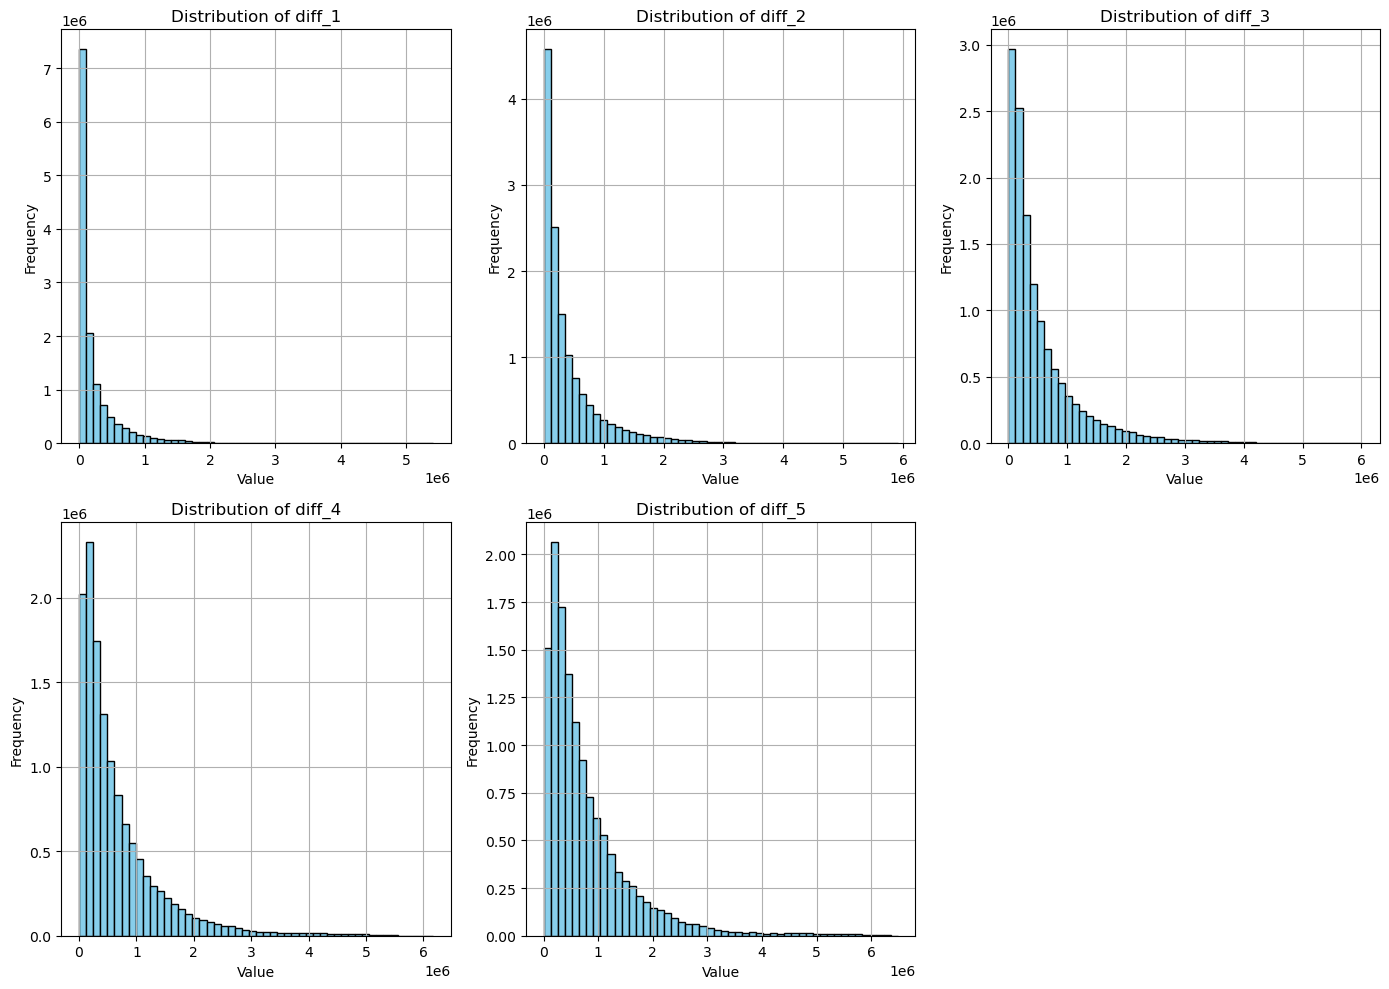

In [26]:
# Plot histograms for each difference column
def plot_histograms(df, columns):
    plt.figure(figsize=(14, 10))
    
    for i, col in enumerate(columns):
        plt.subplot(2, 3, i+1)  # Create a subplot for each column
        df[col].hist(bins=50, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {col}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Define the columns to plot
columns_to_plot = ['diff_1', 'diff_2', 'diff_3', 'diff_4', 'diff_5']

# Call the function to plot histograms
plot_histograms(f_b_final_with_differences, columns_to_plot)


In [27]:
s_het_info = pd.read_excel(s_het_file_path)

In [28]:
s_het_info

,ensg,hgnc,chrom,obs_lof,exp_lof,prior_mean,post_mean,post_lower_95,post_upper_95
0,ENSG00000198488,HGNC:24141,chr11,12.0,8.9777,0.001997,0.000065,0.000007,0.000178
1,ENSG00000164363,HGNC:26441,chr5,31.0,28.5500,0.000973,0.000161,0.000026,0.000442
2,ENSG00000159337,HGNC:30038,chr15,28.0,41.8400,0.000856,0.000170,0.000019,0.000533
3,ENSG00000177558,HGNC:26366,chr19,12.0,9.9101,0.001040,0.000175,0.000025,0.000487
4,ENSG00000062524,HGNC:6721,chr15,40.0,42.6820,0.002000,0.000180,0.000012,0.000589
...,...,...,...,...,...,...,...,...,...
19066,ENSG00000108298,HGNC:10312,chr17,0.0,12.2410,0.349655,0.777394,0.188250,0.999947
19067,ENSG00000142937,HGNC:10441,chr1,0.0,13.8460,0.367146,0.781929,0.176357,0.999976
19068,ENSG00000231500,HGNC:10401,chr6,0.0,11.4500,0.407376,0.823303,0.190498,0.999999
19069,ENSG00000108055,HGNC:2468,chr10,0.0,79.4900,0.376332,0.841343,0.460300,0.998543


In [29]:
s_het_info.isna().sum()

ensg               0
hgnc               0
chrom              0
obs_lof          371
exp_lof          371
prior_mean         0
post_mean          0
post_lower_95      0
post_upper_95      0
dtype: int64

In [30]:
# Function to perform the merge for all forward and backward GeneSymbols and rename the 'post_mean' columns
def merge_s_het_info_with_all(f_b_final_with_differences, s_het_info, num_merges):
    # Rename 'ensg' column in s_het_info to match the GeneSymbol columns in f_b_final_with_differences
    s_het_info = s_het_info.rename(columns={'ensg': 'GeneSymbol'})

    # Iterate over both forward and backward gene symbols
    for i in range(1, num_merges + 1):
        # Forward merge for each GeneSymbol_f
        f_b_final_with_differences = pd.merge(
            f_b_final_with_differences, 
            s_het_info[['GeneSymbol', 'post_mean']], 
            left_on=f'GeneSymbol_{i}', 
            right_on='GeneSymbol', 
            how='left',
            suffixes=('', f'_{i}')
        )
        
        # Rename the post_mean column to indicate the forward direction
        f_b_final_with_differences = f_b_final_with_differences.rename(
            columns={'post_mean': f's_het_post_{i}'}
        )
        
        # Drop the duplicated 'GeneSymbol' column created during the merge
        f_b_final_with_differences = f_b_final_with_differences.drop(columns='GeneSymbol', errors='ignore')

#         # Backward merge for each GeneSymbol_b
#         f_b_final_with_differences = pd.merge(
#             f_b_final_with_differences, 
#             s_het_info[['GeneSymbol', 'post_mean']], 
#             left_on=f'GeneSymbol_b{i}', 
#             right_on='GeneSymbol', 
#             how='left',
#             suffixes=('', f'_b{i}')
#         )
        
#         # Rename the post_mean column to indicate the backward direction
#         f_b_final_with_differences = f_b_final_with_differences.rename(
#             columns={'post_mean': f's_het_post_b{i}'}
#         )
        
#         # Drop the duplicated 'GeneSymbol' column created during the merge
#         f_b_final_with_differences = f_b_final_with_differences.drop(columns='GeneSymbol', errors='ignore')

    return f_b_final_with_differences

# Example usage:
f_b_final_merged_s_het = merge_s_het_info_with_all(f_b_final_with_differences, s_het_info, num_merges=n_closest)

In [31]:
f_b_final_merged_s_het.columns

Index(['diff_1', 'gene_1', 'start_1', 'GeneSymbol_1', 'direction_1', 'diff_2',
       'gene_2', 'start_2', 'GeneSymbol_2', 'direction_2', 'diff_3', 'gene_3',
       'start_3', 'GeneSymbol_3', 'direction_3', 'diff_4', 'gene_4', 'start_4',
       'GeneSymbol_4', 'direction_4', 'diff_5', 'gene_5', 'start_5',
       'GeneSymbol_5', 'direction_5', 'variant', 'pval', 'chr', 'pos',
       's_het_post_1', 's_het_post_2', 's_het_post_3', 's_het_post_4',
       's_het_post_5'],
      dtype='object')

In [32]:
f_b_final_merged_s_het

,diff_1,gene_1,start_1,GeneSymbol_1,direction_1,diff_2,gene_2,start_2,GeneSymbol_2,direction_2,...,direction_5,variant,pval,chr,pos,s_het_post_1,s_het_post_2,s_het_post_3,s_het_post_4,s_het_post_5
0,5508.0,DOC2B,5810.0,ENSG00000272636,f,61878.0,RPH3AL,62180.0,ENSG00000181031,f,...,f,17:302:T:TA,0.281579,17,302.0,0.014912,0.001230,0.001599,0.020787,0.021360
1,124058.0,LIPI,15481134.0,ENSG00000188992,f,231375.0,RBM11,15588451.0,ENSG00000185272,f,...,f,21:15357076:C:A,0.573263,21,15357076.0,0.000977,0.002477,0.011208,0.021438,0.006542
2,124030.0,LIPI,15481134.0,ENSG00000188992,f,231347.0,RBM11,15588451.0,ENSG00000185272,f,...,f,21:15357104:C:G,0.572347,21,15357104.0,0.000977,0.002477,0.011208,0.021438,0.006542
3,114776.0,LIPI,15481134.0,ENSG00000188992,f,222093.0,RBM11,15588451.0,ENSG00000185272,f,...,f,21:15366358:A:G,0.789949,21,15366358.0,0.000977,0.002477,0.021438,0.011208,0.006542
4,230821.0,POTED,14982098.0,ENSG00000166351,b,268215.0,LIPI,15481134.0,ENSG00000188992,f,...,f,21:15212919:G:C,0.094328,21,15212919.0,0.011208,0.000977,0.002477,0.021438,0.006542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13364298,5428.0,PGBD2,249200395.0,ENSG00000185220,b,61618.0,ZNF692,249144205.0,ENSG00000171163,b,...,b,1:249205823:G:A,0.918853,1,249205823.0,0.001772,0.006796,0.003478,0.042778,0.001540
13364299,5411.0,PGBD2,249200395.0,ENSG00000185220,b,61601.0,ZNF692,249144205.0,ENSG00000171163,b,...,b,1:249205806:T:C,0.989577,1,249205806.0,0.001772,0.006796,0.003478,0.042778,0.001540
13364300,5379.0,PGBD2,249200395.0,ENSG00000185220,b,61569.0,ZNF692,249144205.0,ENSG00000171163,b,...,b,1:249205774:T:C,0.767464,1,249205774.0,0.001772,0.006796,0.003478,0.042778,0.001540
13364301,4851.0,PGBD2,249200395.0,ENSG00000185220,b,61041.0,ZNF692,249144205.0,ENSG00000171163,b,...,b,1:249205246:T:A,0.937160,1,249205246.0,0.001772,0.006796,0.003478,0.042778,0.001540


In [33]:
#dont need anymore

# # f_b_final_merged_s_het[['diff_b1']] = abs(f_b_final_merged_s_het[['diff_b1']])
# # f_b_final_merged_s_het[['diff_b2']] = abs(f_b_final_merged_s_het[['diff_b3']])
# # f_b_final_merged_s_het[['diff_b3']] = abs(f_b_final_merged_s_het[['diff_b3']])
# # Loop to apply the absolute value for all diff_b columns
# def apply_abs_diff_b(f_b_final_merged_s_het, num_merges=3):
#     for i in range(1, num_merges + 1):
#         f_b_final_merged_s_het[f'diff_b{i}'] = f_b_final_merged_s_het[f'diff_b{i}'].abs()

#     return f_b_final_merged_s_het

# # Example usage:
# f_b_final_merged_s_het = apply_abs_diff_b(f_b_final_merged_s_het, num_merges=3)

In [34]:
# Function to keep only the distance and s_het measures from the dataframe
def keep_dist_and_s_het_measures(df, num_merges):
    # List to store column names for distance and s_het measures
    columns_to_keep = ['variant', 'chr', 'pos']

    # Loop to collect the diff and s_het_post column names for forward and backward directions
    for i in range(1, num_merges + 1):
        columns_to_keep.append(f'diff_{i}')
#         columns_to_keep.append(f'diff_b{i}')
        columns_to_keep.append(f's_het_post_{i}')
#         columns_to_keep.append(f's_het_post_b{i}')

    # Keep only the relevant columns
    df_filtered = df[columns_to_keep]

    return df_filtered

# Example usage:
filtered_f_b_final = keep_dist_and_s_het_measures(f_b_final_merged_s_het, num_merges=n_closest)

In [35]:
filtered_f_b_final

,variant,chr,pos,diff_1,s_het_post_1,diff_2,s_het_post_2,diff_3,s_het_post_3,diff_4,s_het_post_4,diff_5,s_het_post_5
0,17:302:T:TA,17,302.0,5508.0,0.014912,61878.0,0.001230,259814.0,0.001599,289467.0,0.020787,411441.0,0.021360
1,21:15357076:C:A,21,15357076.0,124058.0,0.000977,231375.0,0.002477,374978.0,0.011208,386360.0,0.021438,500473.0,0.006542
2,21:15357104:C:G,21,15357104.0,124030.0,0.000977,231347.0,0.002477,375006.0,0.011208,386332.0,0.021438,500445.0,0.006542
3,21:15366358:A:G,21,15366358.0,114776.0,0.000977,222093.0,0.002477,377078.0,0.021438,384260.0,0.011208,491191.0,0.006542
4,21:15212919:G:C,21,15212919.0,230821.0,0.011208,268215.0,0.000977,375532.0,0.002477,530517.0,0.021438,644630.0,0.006542
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13364298,1:249205823:G:A,1,249205823.0,5428.0,0.001772,61618.0,0.006796,73414.0,0.003478,101178.0,0.042778,361200.0,0.001540
13364299,1:249205806:T:C,1,249205806.0,5411.0,0.001772,61601.0,0.006796,73397.0,0.003478,101161.0,0.042778,361183.0,0.001540
13364300,1:249205774:T:C,1,249205774.0,5379.0,0.001772,61569.0,0.006796,73365.0,0.003478,101129.0,0.042778,361151.0,0.001540
13364301,1:249205246:T:A,1,249205246.0,4851.0,0.001772,61041.0,0.006796,72837.0,0.003478,100601.0,0.042778,360623.0,0.001540


In [36]:
# Function to compute s_het weighted by 1/distance per gene-SNP pair
def compute_weighted_s_het(df, num_merges):
    # Loop to compute the weighted s_het for both forward and backward directions
    for i in range(1, num_merges + 1):
        # Calculate inverse distance for forward and backward directions
        df[f'inv_dist_{i}'] = 1 / df[f'diff_{i}']
#         df[f'inv_dist_b{i}'] = 1 / df[f'diff_b{i}']
        
        # Compute weighted s_het by multiplying s_het by inverse distance
        df[f'weighted_s_het_{i}'] = df[f'inv_dist_{i}'] * df[f's_het_post_{i}']
#         df[f'weighted_s_het_b{i}'] = df[f'inv_dist_b{i}'] * df[f's_het_post_b{i}']

    return df

# Example usage:
weighted_f_b_final = compute_weighted_s_het(filtered_f_b_final, num_merges=n_closest)

/var/folders/6r/gppxzrp57j9ggbttd9chp8cm0000gn/T/ipykernel_50133/1400562633.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'inv_dist_{i}'] = 1 / df[f'diff_{i}']
/var/folders/6r/gppxzrp57j9ggbttd9chp8cm0000gn/T/ipykernel_50133/1400562633.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'weighted_s_het_{i}'] = df[f'inv_dist_{i}'] * df[f's_het_post_{i}']
/var/folders/6r/gppxzrp57j9ggbttd9chp8cm0000gn/T/ipykernel_50133/1400562633.py:6: SettingWithCopyWarning: 
A value is trying to be set on a c

In [37]:
weighted_f_b_final

,variant,chr,pos,diff_1,s_het_post_1,diff_2,s_het_post_2,diff_3,s_het_post_3,diff_4,...,inv_dist_1,weighted_s_het_1,inv_dist_2,weighted_s_het_2,inv_dist_3,weighted_s_het_3,inv_dist_4,weighted_s_het_4,inv_dist_5,weighted_s_het_5
0,17:302:T:TA,17,302.0,5508.0,0.014912,61878.0,0.001230,259814.0,0.001599,289467.0,...,0.000182,2.707407e-06,0.000016,1.987007e-08,0.000004,6.153787e-09,0.000003,7.181060e-08,0.000002,5.191534e-08
1,21:15357076:C:A,21,15357076.0,124058.0,0.000977,231375.0,0.002477,374978.0,0.011208,386360.0,...,0.000008,7.873092e-09,0.000004,1.070699e-08,0.000003,2.988869e-08,0.000003,5.548608e-08,0.000002,1.307121e-08
2,21:15357104:C:G,21,15357104.0,124030.0,0.000977,231347.0,0.002477,375006.0,0.011208,386332.0,...,0.000008,7.874869e-09,0.000004,1.070829e-08,0.000003,2.988646e-08,0.000003,5.549010e-08,0.000002,1.307195e-08
3,21:15366358:A:G,21,15366358.0,114776.0,0.000977,222093.0,0.002477,377078.0,0.021438,384260.0,...,0.000009,8.509793e-09,0.000005,1.115447e-08,0.000003,5.685190e-08,0.000003,2.916671e-08,0.000002,1.331822e-08
4,21:15212919:G:C,21,15212919.0,230821.0,0.011208,268215.0,0.000977,375532.0,0.002477,530517.0,...,0.000004,4.855537e-08,0.000004,3.641556e-09,0.000003,6.596855e-09,0.000002,4.040888e-08,0.000002,1.014813e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13364298,1:249205823:G:A,1,249205823.0,5428.0,0.001772,61618.0,0.006796,73414.0,0.003478,101178.0,...,0.000184,3.264536e-07,0.000016,1.102965e-07,0.000014,4.737216e-08,0.000010,4.227965e-07,0.000003,4.262569e-09
13364299,1:249205806:T:C,1,249205806.0,5411.0,0.001772,61601.0,0.006796,73397.0,0.003478,101161.0,...,0.000185,3.274792e-07,0.000016,1.103269e-07,0.000014,4.738314e-08,0.000010,4.228675e-07,0.000003,4.262770e-09
13364300,1:249205774:T:C,1,249205774.0,5379.0,0.001772,61569.0,0.006796,73365.0,0.003478,101129.0,...,0.000186,3.294274e-07,0.000016,1.103843e-07,0.000014,4.740380e-08,0.000010,4.230013e-07,0.000003,4.263148e-09
13364301,1:249205246:T:A,1,249205246.0,4851.0,0.001772,61041.0,0.006796,72837.0,0.003478,100601.0,...,0.000206,3.652834e-07,0.000016,1.113391e-07,0.000014,4.774744e-08,0.000010,4.252214e-07,0.000003,4.269389e-09


In [38]:
# Function to keep only the weighted s_het values from the dataframe
def keep_weighted_s_het(df, num_merges):
    # List to store column names for weighted s_het values
    columns_to_keep = ['variant', 'chr', 'pos']

    # Loop to collect the weighted_s_het column names for forward and backward directions
    for i in range(1, num_merges + 1):
        columns_to_keep.append(f'weighted_s_het_{i}')
#         columns_to_keep.append(f'weighted_s_het_b{i}')

    # Keep only the relevant columns
    df_filtered = df[columns_to_keep]

    return df_filtered

# Example usage:
weighted_s_het_only = keep_weighted_s_het(weighted_f_b_final, num_merges=n_closest)

In [39]:
weighted_s_het_only

,variant,chr,pos,weighted_s_het_1,weighted_s_het_2,weighted_s_het_3,weighted_s_het_4,weighted_s_het_5
0,17:302:T:TA,17,302.0,2.707407e-06,1.987007e-08,6.153787e-09,7.181060e-08,5.191534e-08
1,21:15357076:C:A,21,15357076.0,7.873092e-09,1.070699e-08,2.988869e-08,5.548608e-08,1.307121e-08
2,21:15357104:C:G,21,15357104.0,7.874869e-09,1.070829e-08,2.988646e-08,5.549010e-08,1.307195e-08
3,21:15366358:A:G,21,15366358.0,8.509793e-09,1.115447e-08,5.685190e-08,2.916671e-08,1.331822e-08
4,21:15212919:G:C,21,15212919.0,4.855537e-08,3.641556e-09,6.596855e-09,4.040888e-08,1.014813e-08
...,...,...,...,...,...,...,...,...
13364298,1:249205823:G:A,1,249205823.0,3.264536e-07,1.102965e-07,4.737216e-08,4.227965e-07,4.262569e-09
13364299,1:249205806:T:C,1,249205806.0,3.274792e-07,1.103269e-07,4.738314e-08,4.228675e-07,4.262770e-09
13364300,1:249205774:T:C,1,249205774.0,3.294274e-07,1.103843e-07,4.740380e-08,4.230013e-07,4.263148e-09
13364301,1:249205246:T:A,1,249205246.0,3.652834e-07,1.113391e-07,4.774744e-08,4.252214e-07,4.269389e-09


In [40]:
rows_with_na = weighted_s_het_only[weighted_s_het_only.isna().any(axis=1)]
rows_with_na

,variant,chr,pos,weighted_s_het_1,weighted_s_het_2,weighted_s_het_3,weighted_s_het_4,weighted_s_het_5
294,10:177393:C:T,10,177393.0,1.485684e-04,NaN,1.177985e-06,3.659102e-07,7.517635e-07
296,10:130161:T:C,10,130161.0,NaN,8.906297e-06,8.851023e-07,3.419965e-07,7.124947e-07
297,10:151929:G:T,10,151929.0,1.571457e-05,NaN,9.996492e-07,3.526173e-07,7.300704e-07
298,10:173893:T:A,10,173893.0,6.871744e-05,NaN,1.149791e-06,3.640240e-07,7.487057e-07
300,10:94545:C:T,10,94545.0,NaN,5.211833e-06,7.453598e-07,3.259342e-07,6.854939e-07
...,...,...,...,...,...,...,...,...
13363918,1:248886764:A:G,1,248886764.0,3.653544e-08,3.302341e-08,NaN,2.489449e-08,1.745353e-08
13363919,1:248886777:T:C,1,248886777.0,3.652417e-08,3.301848e-08,NaN,2.489206e-08,1.745201e-08
13363920,1:248887065:T:C,1,248887065.0,3.627633e-08,3.290969e-08,NaN,2.483827e-08,1.741850e-08
13363921,1:248861986:A:G,1,248861986.0,8.867362e-08,4.615139e-08,NaN,3.059548e-08,2.091645e-08


In [41]:
weighted_s_het_only.isna().sum()

variant                  0
chr                      0
pos                      0
weighted_s_het_1    271407
weighted_s_het_2    313104
weighted_s_het_3    337292
weighted_s_het_4    360964
weighted_s_het_5    340066
dtype: int64

# LD Score Process

## Make annot file

In [43]:
# Rename columns in the weighted_s_het_only DataFrame
weighted_s_het_only.rename(columns={
    'chr': 'CHR',
    'pos': 'BP',
    'variant': 'SNP'
}, inplace=True)

# Add a 'CM' column filled with zeros (if you don't have cM data)
weighted_s_het_only['CM'] = 0.0

# Prepare the annotation DataFrame
annot_df = weighted_s_het_only[['CHR', 'BP', 'SNP', 'CM', 'weighted_s_het_1', 'weighted_s_het_2', 'weighted_s_het_3', 'weighted_s_het_4', 'weighted_s_het_5']]
annot_df = annot_df.sort_values(['CHR', 'BP'])

# Save the updated annotation file
output_file_path = "/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Capstone/all_chr_SNP.annot"
annot_df.to_csv(output_file_path, sep='\t', index=False)

# Filter for chromosome 22
annot_df_22 = annot_df[annot_df['CHR'] == 22]
output_file_path = "/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Capstone/22_SNP.annot"
annot_df_22.to_csv(output_file_path, sep='\t', index=False)

/var/folders/6r/gppxzrp57j9ggbttd9chp8cm0000gn/T/ipykernel_50133/2173135090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_s_het_only.rename(columns={
/var/folders/6r/gppxzrp57j9ggbttd9chp8cm0000gn/T/ipykernel_50133/2173135090.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weighted_s_het_only['CM'] = 0.0


In [44]:
annot_df

,CHR,BP,SNP,CM,weighted_s_het_1,weighted_s_het_2,weighted_s_het_3,weighted_s_het_4,weighted_s_het_5
16521,1,15791.0,1:15791:C:T,0.0,4.576529e-08,NaN,3.596226e-09,1.250000e-09,4.357337e-09
38042,1,69487.0,1:69487:G:A,0.0,5.583186e-07,NaN,3.840717e-09,1.332854e-09,4.640432e-09
4238,1,69569.0,1:69569:T:C,0.0,5.472867e-07,NaN,3.841116e-09,1.332989e-09,4.640892e-09
3159,1,139853.0,1:139853:C:T,0.0,3.051348e-08,NaN,4.216360e-09,1.459641e-09,5.072284e-09
57575,1,692794.0,1:692794:CA:C,0.0,NaN,1.821799e-08,5.780533e-09,1.887685e-08,5.980877e-09
...,...,...,...,...,...,...,...,...,...
5216670,22,51229717.0,22:51229717:A:T,0.0,1.265928e-07,1.510308e-07,2.122508e-06,9.153054e-09,3.706323e-06
5216662,22,51229805.0,22:51229805:T:C,0.0,1.261262e-07,1.507809e-07,2.120911e-06,9.148278e-09,3.704612e-06
5216666,22,51231220.0,22:51231220:A:G,0.0,1.190696e-07,1.468730e-07,2.095559e-06,9.072149e-09,3.677309e-06
5216644,22,51237063.0,22:51237063:T:C,0.0,9.672352e-08,1.326739e-07,1.996989e-06,8.770760e-09,3.568704e-06


In [49]:
annot_df.isna().sum()

CHR                      0
BP                       0
SNP                      0
CM                       0
weighted_s_het_1    271407
weighted_s_het_2    313104
weighted_s_het_3    337292
weighted_s_het_4    360964
weighted_s_het_5    340066
dtype: int64

In [46]:
annot_df_22

,CHR,BP,SNP,CM,weighted_s_het_1,weighted_s_het_2,weighted_s_het_3,weighted_s_het_4,weighted_s_het_5
50825,22,16464274.0,22:16464274:A:C,0.0,4.456943e-09,1.679279e-09,2.546518e-10,8.102880e-09,1.045491e-07
50844,22,16488635.0,22:16488635:C:A,0.0,4.643177e-09,1.732019e-09,2.611532e-10,8.286126e-09,1.068466e-07
47715,22,16488702.0,22:16488702:G:C,0.0,4.643711e-09,1.732169e-09,2.611715e-10,8.286642e-09,1.068530e-07
47775,22,16495833.0,22:16495833:C:A,0.0,4.701220e-09,1.748242e-09,2.631382e-10,8.341868e-09,1.075449e-07
47542,22,16498458.0,22:16498458:G:A,0.0,4.722750e-09,1.754235e-09,2.638696e-10,8.362382e-09,1.078018e-07
...,...,...,...,...,...,...,...,...,...
5216670,22,51229717.0,22:51229717:A:T,0.0,1.265928e-07,1.510308e-07,2.122508e-06,9.153054e-09,3.706323e-06
5216662,22,51229805.0,22:51229805:T:C,0.0,1.261262e-07,1.507809e-07,2.120911e-06,9.148278e-09,3.704612e-06
5216666,22,51231220.0,22:51231220:A:G,0.0,1.190696e-07,1.468730e-07,2.095559e-06,9.072149e-09,3.677309e-06
5216644,22,51237063.0,22:51237063:T:C,0.0,9.672352e-08,1.326739e-07,1.996989e-06,8.770760e-09,3.568704e-06


In [50]:
annot_df_22.isna().sum()

CHR                    0
BP                     0
SNP                    0
CM                     0
weighted_s_het_1    2144
weighted_s_het_2    3390
weighted_s_het_3    2048
weighted_s_het_4    3401
weighted_s_het_5    2325
dtype: int64

### Load BIM

In [52]:
# Load the normal bim file
bim_file_path = "/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/ldsc/1kg_eur/22.bim"  # Adjust this path as needed
bim_file = pd.read_csv(bim_file_path, delim_whitespace=True, header=None)

# Rename the columns for clarity
bim_file.columns = ['CHR', 'SNP', 'CM', 'BP', 'A1', 'A2']

# Display the loaded DataFrame
bim_file

,CHR,SNP,CM,BP,A1,A2
0,22,rs9617528,0.059576,16061016,C,T
1,22,rs4911642,2.127458,16504399,C,T
2,22,rs140378,2.246184,16877135,G,C
3,22,rs131560,2.246335,16877230,C,G
4,22,rs7287144,2.252105,16886873,G,A
...,...,...,...,...,...,...
19151,22,rs13056621,75.088001,51181759,A,G
19152,22,rs3865766,75.091403,51186228,T,C
19153,22,rs3888396,75.110507,51211392,C,T
19154,22,rs2238837,75.111632,51212875,C,A


### Merge and Clean BIM

In [55]:
# Merge annotation with BIM file
merged_annot_22 = pd.merge(bim_file[['CHR', 'BP', 'SNP']], annot_df_22, on=['CHR', 'BP'], how='inner')

# Clean up merged DataFrame
merged_annot_22 = merged_annot_22.rename(columns={'SNP_x': 'SNP'})
merged_annot_22 = merged_annot_22.drop(columns=['SNP_y'])
merged_annot_22 = merged_annot_22[['CHR', 'BP', 'SNP', 'CM', 'weighted_s_het_1', 'weighted_s_het_2', 'weighted_s_het_3', 'weighted_s_het_4', 'weighted_s_het_5']]

# Check for rows with NA values
rows_with_na = merged_annot_22[merged_annot_22.isna().any(axis=1)]
rows_with_na
# Count of NA values in each column
na_counts = merged_annot_22.isna().sum()
print("Count of NA values in each column:\n", na_counts)

# Save merged annotation file
output_file_path = "/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Capstone/22_merged_SNP.annot"
merged_annot_22.to_csv(output_file_path, sep='\t', index=False)

rows_with_na

Count of NA values in each column:
 CHR                   0
BP                    0
SNP                   0
CM                    0
weighted_s_het_1    136
weighted_s_het_2    272
weighted_s_het_3    181
weighted_s_het_4    257
weighted_s_het_5    169
dtype: int64


,CHR,BP,SNP,CM,weighted_s_het_1,weighted_s_het_2,weighted_s_het_3,weighted_s_het_4,weighted_s_het_5
1774,22,20235200,rs696880,0.0,1.877994e-05,1.130823e-07,1.640604e-07,8.955093e-07,NaN
1775,22,20241160,rs1567871,0.0,9.621993e-06,1.242037e-07,1.547676e-07,8.525298e-07,NaN
1776,22,20244616,rs9606296,0.0,7.500957e-06,1.317153e-07,1.498459e-07,NaN,8.294460e-07
1777,22,20248391,rs855050,0.0,6.045340e-06,1.410319e-07,1.448156e-07,NaN,NaN
1778,22,20249918,rs1807466,0.0,5.605338e-06,1.451858e-07,1.428754e-07,NaN,NaN
...,...,...,...,...,...,...,...,...,...
18760,22,51078251,rs4040041,0.0,9.037495e-08,7.171196e-06,1.809004e-05,6.704599e-08,NaN
18761,22,51080760,rs134774,0.0,7.879303e-08,7.732008e-06,1.699735e-05,6.439153e-08,NaN
18762,22,51087348,rs9616807,0.0,9.729986e-06,5.895475e-08,1.467057e-05,5.832790e-08,NaN
18763,22,51089213,rs6009945,0.0,1.049793e-05,5.503229e-08,1.412326e-05,5.681337e-08,NaN


### Filter BIM

In [56]:
# Filter the BIM file based on merged annotation
filtered_bim_df = pd.merge(bim_file, merged_annot_22[['CHR', 'SNP']], on=['CHR', 'SNP'], how='inner')

# Optionally, save the filtered BIM file
filtered_bim_file_path = '/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/ldsc/1kg_eur/filtered_22.bim'
filtered_bim_df.to_csv(filtered_bim_file_path, sep='\t', index=False, header=False)

# Check for duplicates in the annotation DataFrame and remove them
merged_annot_22 = merged_annot_22.drop_duplicates(subset=['SNP'])

# Filter the annotation file based on SNPs in the BIM file
filtered_annot = merged_annot_22[merged_annot_22['SNP'].isin(bim_file['SNP'])]

# Ensure the order matches the BIM file
filtered_annot = filtered_annot.set_index('SNP').reindex(bim_file['SNP']).reset_index()

# Save the filtered annotation file
filtered_annot.to_csv("/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Capstone/filtered_22_merged_SNP.annot", sep="\t", index=False)

print("Filtered annotation file saved successfully!")
filtered_annot


Filtered annotation file saved successfully!


,SNP,CHR,BP,CM,weighted_s_het_1,weighted_s_het_2,weighted_s_het_3,weighted_s_het_4,weighted_s_het_5
0,rs9617528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,rs4911642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,rs140378,22.0,16877135.0,0.0,1.391731e-08,3.470001e-09,4.405055e-10,1.296032e-08,1.644951e-07
3,rs131560,22.0,16877230.0,0.0,1.392411e-08,3.470853e-09,4.405795e-10,1.296211e-08,1.645168e-07
4,rs7287144,22.0,16886873.0,0.0,1.465081e-08,3.559530e-09,4.482213e-10,1.314620e-08,1.667502e-07
...,...,...,...,...,...,...,...,...,...
19151,rs13056621,22.0,51181759.0,0.0,1.561574e-06,1.245921e-07,3.599541e-06,1.279357e-08,4.953352e-06
19152,rs3865766,22.0,51186228.0,0.0,8.349313e-07,1.528547e-07,3.380337e-06,1.233634e-08,4.802770e-06
19153,rs3888396,22.0,51211392.0,0.0,5.512338e-07,2.306339e-07,2.517184e-06,1.026969e-08,4.100807e-06
19154,rs2238837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Get Filtered SNPs

In [57]:
filtered_snps = filtered_annot['SNP'].unique()  # Get unique SNPs to avoid duplicates

# Save the SNPs to a text file
with open('/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/ldsc/1kg_eur/filtered_snps.txt', 'w') as f:
    for snp in filtered_snps:
        f.write(f"{snp}\n")  # Write each SNP on a new line

## Run PLINK
-----

plink --bfile /Users/oliverkafka/Documents/NYU/3rd\ Sem\ NYU/Captone\ Project/ldsc/1kg_eur/22       --extract filtered_snps.txt       --make-bed       --out /Users/oliverkafka/Documents/NYU/3rd\ Sem\ NYU/Captone\ Project/ldsc/1kg_eur/filtered_22

## Run LD Score
-----

python ../ldsc.py   --bfile "/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/ldsc/1kg_eur/filtered_22"   --l2   --ld-wind-cm 1   --annot "/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Capstone/filtered_22_merged_SNP.annot"   --out "/Users/oliverkafka/Documents/NYU/3rd Sem NYU/Captone Project/Capstone/chr22_output"